#semantic segmentation

In semantic segmentation, each pixel is classified according to the class of the object it belongs to (e.g., road, car, pedestrian, building, etc.), as shown in the Figure 

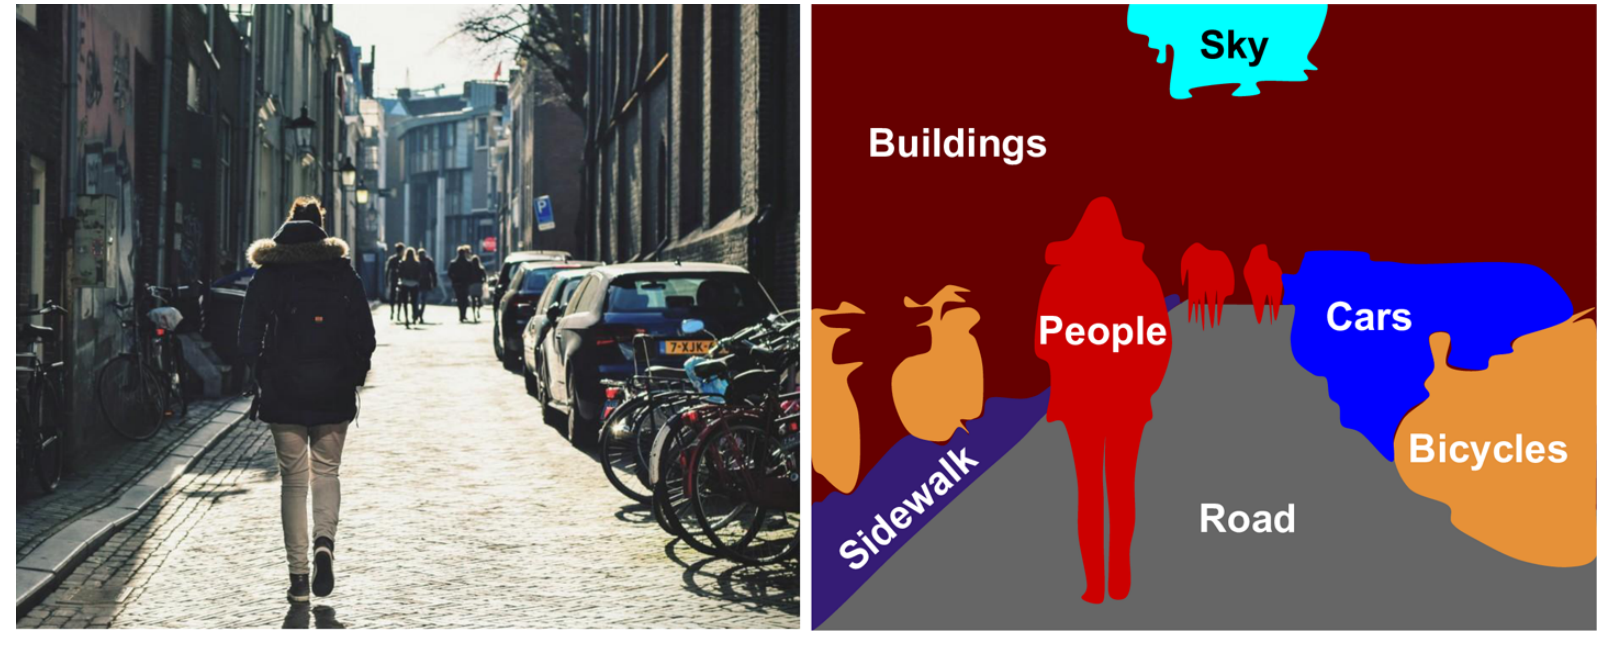



Note that different objects of the same class are not distinguished. For example, all the bicycles on the right side of the segmented image end up as one big lump of pixels. 

Themain difficulty in this task is that when images go through a regular CNN, they gradually lose their spatial resolution (due to the layers with strides greater than 1); so, a
regular CNN may end up knowing that there’s a person somewhere in the bottom left of the image, but it will not be much more precise than that.


In [ ]:
# import python libraries for the project
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import os
import time
import glob

#Downloading the data
https://arxiv.org/abs/1811.12596


We will use the Crowd Instance-level Human Parsing Dataset for training our model. The Crowd Instance-level Human Parsing (CIHP) dataset has 38,280 diverse human images. Each image in CIHP is labeled with pixel-wise annotations for 20 categories, as well as instance-level identification. This dataset can be used for the "human part segmentation" task.

In [ ]:
!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:19<00:00, 152MB/s]


#Read the images paths


In [ ]:
# create a function to get the folder path that contains the images
# return a pandas dataframe that have the input images with there masks


def create_dataset(folder_path, folder_type="Training"):
    images = sorted(
        glob.glob(folder_path + "/" + folder_type + "/Images/*.jpg")
    )  # get the paths of images and sort them
    masks = sorted(
        glob.glob(folder_path + "/" + folder_type + "/Category_ids/*.png")
    )  # get the paths of mask and sort them

    data = {"images": images, "masks": masks}

    return pd.DataFrame(data)  # return the pandas dataframe


train_data = create_dataset(
    "/content/instance-level_human_parsing/instance-level_human_parsing"
)
val_data = create_dataset(
    "/content/instance-level_human_parsing/instance-level_human_parsing", "Validation"
)


val_data

,images,masks
0,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
1,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
2,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
3,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
4,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
...,...,...
4995,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
4996,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
4997,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...
4998,/content/instance-level_human_parsing/instance...,/content/instance-level_human_parsing/instance...


In [ ]:
NUM_CLASSES = 20  # number of class in mask images

In [ ]:
def read_image(x, y):
    # read_image function that will read images from the paths
    # read image for x path

    x = tf.io.read_file(x)
    # decode the image to jpeg for x
    x = tf.image.decode_jpeg(x, channels=3)
    # This will convert to float values in [0, 1]for x
    x = tf.image.convert_image_dtype(x, tf.float32)
    # resize images to target model size for x
    x = tf.image.resize(x, [256, 256])
    # make sure the pixels value are between 0,1 for x
    x = tf.clip_by_value(x, clip_value_min=0, clip_value_max=1)

    # read image for y path
    y = tf.io.read_file(y)
    # decode the image to png for y

    y = tf.image.decode_png(y, channels=1)

    # resize images to target model size for y
    # note : when you resize the image using the NEAREST_NEIGHBOR method because it keeps the values of the pixels the same
    y = tf.image.resize(y, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # reshape it from (256,256,1) to (256,256)
    y = tf.reshape(y, shape=(256, 256))
    # create the one hot of y
    y = tf.one_hot(y, depth=NUM_CLASSES)

    return x, y


def train_preprocess(x, y):
    # train_preprocess applies data augmentation from the training images

    # data augmentation for x

    seed = np.random.randint(low=0, high=100, size=1)

    tf.compat.v1.set_random_seed(seed)
    x = tf.image.random_flip_left_right(x, seed=seed[0])

    x = tf.image.random_brightness(x, max_delta=32.0 / 255.0)
    x = tf.image.random_saturation(x, lower=0.5, upper=1.5)

    # Make sure the image is still between [0, 1]
    x = tf.clip_by_value(x, 0.0, 1.0)

    # it needs to convert the y from the one hot to the normal image and we are using the argmax to do that
    # note set the axis at the last axis
    y = tf.argmax(y, axis=-1)
    # reshape it from (256,256) to (256,256,1) so that we can implement the flip
    y = tf.reshape(y, shape=(256, 256, 1))
    # randomly flip the mask but it should be the same seed as the image too
    y = tf.image.random_flip_left_right(y, seed=seed[0])
    # reshape it from  (256,256,1)to  (256,256) so that we can do one hot on it again
    y = tf.reshape(y, shape=(256, 256))
    y = tf.one_hot(y, depth=NUM_CLASSES)

    return x, y

#Create the data pipeline

In [ ]:
# create the data pipline
def dataset_creater(x, y, training=False):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.shuffle(1028, reshuffle_each_iteration=True)
    data = data.map(
        read_image, num_parallel_calls=tf.data.AUTOTUNE
    )  # read images from paths

    if training:
        # apply data augmentation
        data = data.map(train_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    data = data.batch(32)
    data = data.prefetch(tf.data.AUTOTUNE)
    return data


# create the train data pipline
train_dataset = dataset_creater(train_data.images, train_data.masks, training=True)
# create the test data pipline

test_dataset = dataset_creater(val_data.images, val_data.masks)

#plot images 

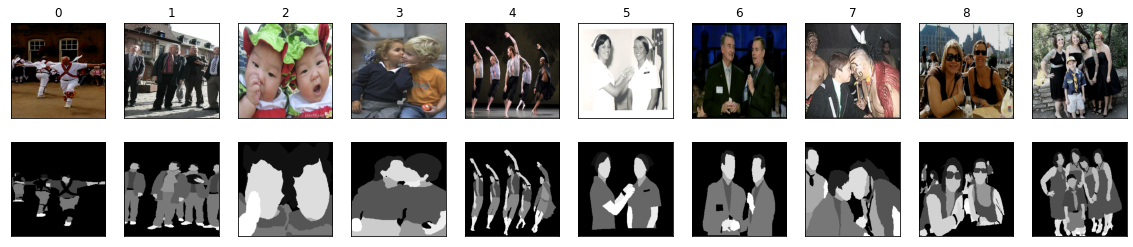

In [ ]:
n = 10
plt.figure(figsize=(20, 4))

for x, y in train_dataset.take(1):

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.title(f"{i}")
        plt.imshow(tf.squeeze(x[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        bx = plt.subplot(2, n, n + i + 1)

        plt.imshow(tf.squeeze(tf.argmax(y[i], -1)))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)


plt.show()

In [ ]:
y.shape

TensorShape([32, 256, 256, 20])

In [ ]:
set(y[0].numpy().reshape(-1))

{0.0, 1.0}

#Model 

##U-Net

U-Net is an architecture for semantic segmentation. It consists of a contracting path (encoder) and an expansive path (decoder). The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a BatchNormalization than (Leaky_relu) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a BatchNormalization than (Leaky_relu). At the final layer a 1x1 convolution is used to map each 32-component feature vector to the desired number of classes. 

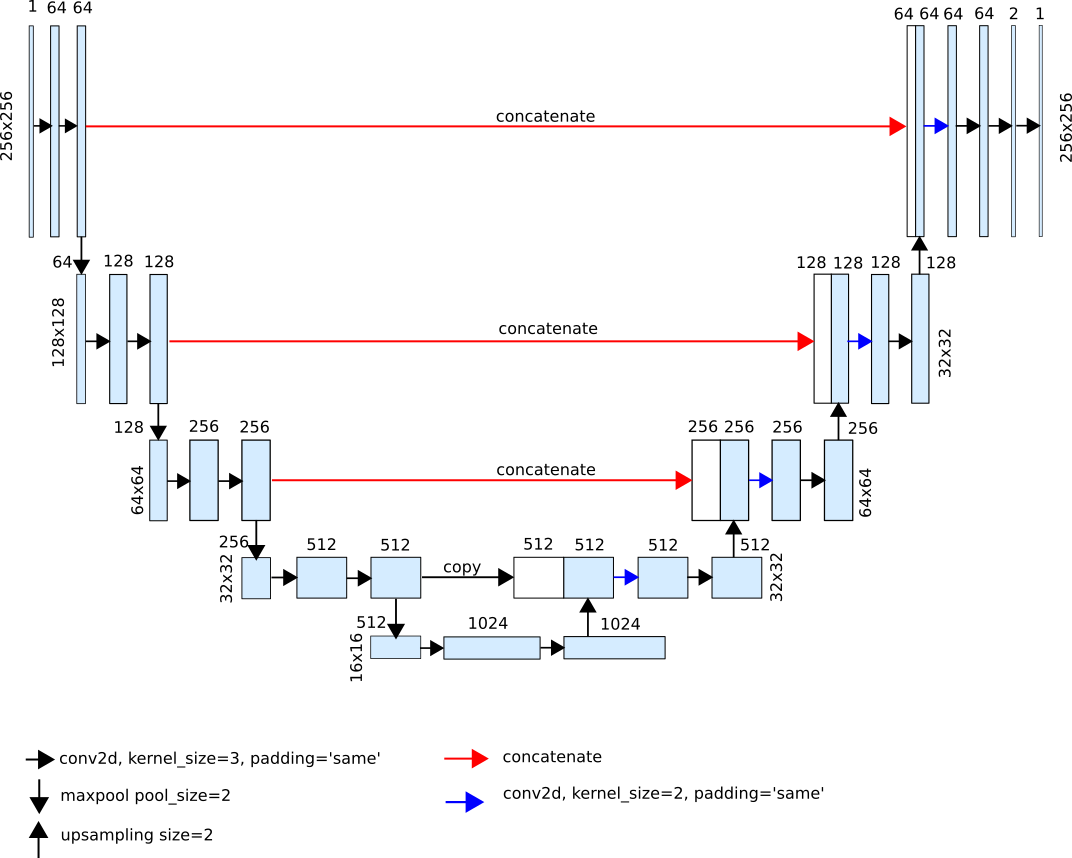

##Convolution Block 



In [ ]:
# Create the convolution block
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ConvBlock, self).__init__()
        # add conv2d to the block with BN layer
        self.Conv_1 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=(3, 3), padding="same", use_bias=False
        )
        self.BN_1 = tf.keras.layers.BatchNormalization()
        # add conv2d to the block with BN layer
        self.Conv_2 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=(3, 3), padding="same", use_bias=False
        )
        self.BN_2 = tf.keras.layers.BatchNormalization()

    def call(self, x):
        x = self.Conv_1(x)
        x = self.BN_1(x)
        x = tf.nn.leaky_relu(x)

        x = self.Conv_2(x)
        x = self.BN_2(x)
        x = tf.nn.leaky_relu(x)

        return x

##Encoder Block

In [ ]:
# create the encoder block
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(EncoderBlock, self).__init__()
        # call the conv block
        self.Conv_block = ConvBlock(filters)
        # add the maxpooling layer
        self.Max_pool = tf.keras.layers.MaxPooling2D()

    def call(self, x):
        x = self.Conv_block(x)
        p = self.Max_pool(x)
        # return x and y
        # x : representing the output that will concatenate with the decoder conv block
        # p : representing the output to next block in the encoder
        return x, p

## Decoder Block

In [ ]:
# create the decoder block


class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(DecoderBlock, self).__init__()
        # using the transpose Conv2D to upsample images
        self.ConvTranspose = tf.keras.layers.Conv2DTranspose(
            filters, kernel_size=(2, 2), strides=(2, 2), padding="same"
        )
        self.Conv_block = ConvBlock(filters)

    def call(self, input, skip_features):
        # input : representing the output from the previous block
        # skip_features : representing the output from the encoder
        x = self.ConvTranspose(input)
        # we will concatenate the upsamled feature maps with the output of encoder layer that have the same Width & Height
        x = tf.keras.layers.concatenate([x, skip_features])
        x = self.Conv_block(x)
        return x

##the U-Net Model

In [ ]:
# Create the model
class SemanticSegmentation(tf.keras.Model):
    def __init__(self, n_classes=NUM_CLASSES):
        super(SemanticSegmentation, self).__init__()
        # Create the encoder path
        self.encoder_block_1 = EncoderBlock(32)
        self.encoder_block_2 = EncoderBlock(64)
        self.encoder_block_3 = EncoderBlock(128)
        self.encoder_block_4 = EncoderBlock(256)
        self.encoder_block_5 = EncoderBlock(512)
        # bottle neck feature maps
        self.conv_block_6 = ConvBlock(1028)
        # create the decoder path
        self.decoder_block_7 = DecoderBlock(512)
        self.decoder_block_8 = DecoderBlock(256)
        self.decoder_block_9 = DecoderBlock(128)
        self.decoder_block_10 = DecoderBlock(64)
        self.decoder_block_11 = DecoderBlock(32)

        # using 1x1 conv2d as output
        self.out = tf.keras.layers.Conv2D(n_classes, kernel_size=(1, 1))

    def call(self, x):
        # Create the encoder path
        # each encoder block will return x and s
        # using x as input for the next encoder block
        # using Sn as input for the decoder blocks to create the connection between encoder and decoder blocks
        s1, x = self.encoder_block_1(x)
        s2, x = self.encoder_block_2(x)
        s3, x = self.encoder_block_3(x)
        s4, x = self.encoder_block_4(x)
        s5, x = self.encoder_block_5(x)

        x = self.conv_block_6(x)
        x = self.decoder_block_7(x, s5)
        x = self.decoder_block_8(x, s4)
        x = self.decoder_block_9(x, s3)
        x = self.decoder_block_10(x, s2)
        x = self.decoder_block_11(x, s1)
        x = self.out(x)
        x = tf.nn.softmax(x)

        return x

    def build_model(self, dim=(256, 256, 3)):
        x = tf.keras.layers.Input(dim)
        return tf.keras.Model(inputs=[x], outputs=[self.call(x)])

In [ ]:
model = SemanticSegmentation()
model.build_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_bloak (EncoderBloak)   ((None, 256, 256, 3  10336       ['input_1[0][0]']                
                                2),                                                               
                                 (None, 128, 128, 3                                               
                                2))                                                               
                                                                                              

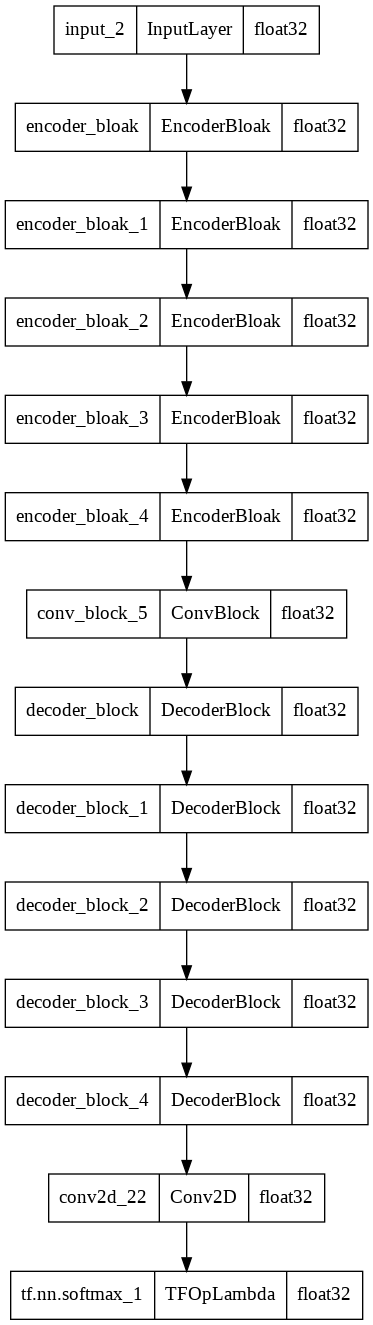

In [ ]:
tf.keras.utils.plot_model(model.build_model(), show_dtype=True)

#Define the Loss function and the optimizer

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

#Train The Model 

In [ ]:
model.compile(optimizer=optimizer, loss=loss_object, metrics=["acc"])
model.fit(train_dataset, epochs=25, validation_data=test_dataset)

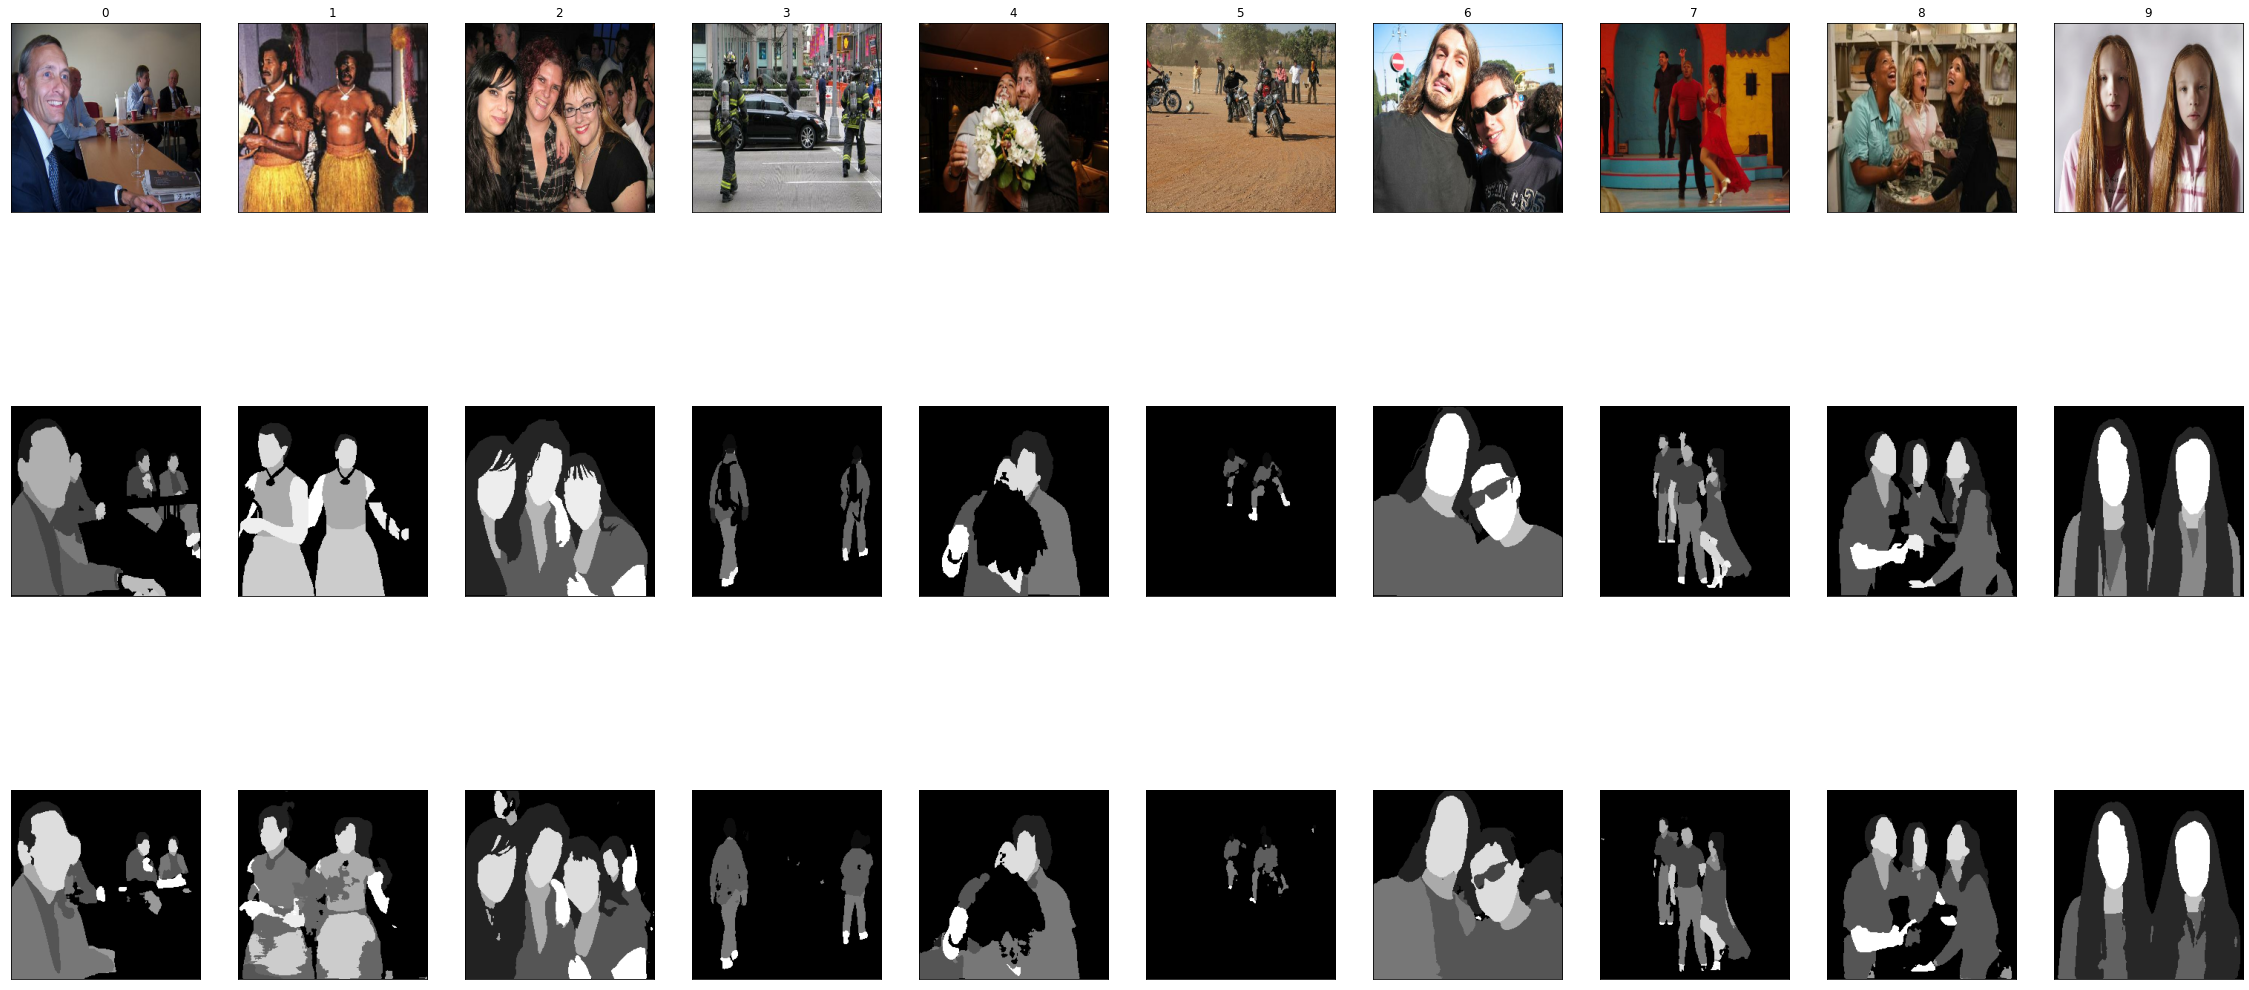

In [ ]:
# plot the images

for x, y in test_dataset.take(1):
    pred = model(x, training=False)
    pred = tf.argmax(pred, axis=-1)
    n = 10
    plt.figure(figsize=(40, 20))

    for i in range(n):
        ax = plt.subplot(3, n, i + 1)

        plt.title(f"{i}")
        plt.imshow(tf.squeeze(x[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        bx = plt.subplot(3, n, n + i + 1)

        plt.imshow(tf.squeeze(tf.argmax(y[i], axis=-1)))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)

        cx = plt.subplot(3, n, n + i + n + 1)

        plt.imshow(tf.squeeze(pred[i]))
        plt.gray()
        cx.get_xaxis().set_visible(False)
        cx.get_yaxis().set_visible(False)


plt.show()